# Autoencoder

## Libraries

- anndata: 0.10.7
- matplotlib: 3.8.4
- numpy: 1.26.4
- pytorch: 2.2.2 

In [49]:
from random import choice

import anndata as ad
from anndata.experimental import AnnLoader
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as f

### Hyperparameters

In [67]:
# Model size
input_layer = 1000
layer_one = 500
layer_two = 250
layer_three = 100
latent_space = 50
# Dataloaders
batch_size = 32
# Optimizer
learning_rate = 1e-1
weight_decay = 1e-8
# Training
folds = 1
epochs = 1

## Model Structure

The **autoencoder*+ is comprised of two primary components: the **encoder** and the **decoder**. The encoder is responsible for reducing the dimensionality of the input tensor. The decoder, in turn, attempts to reconstruct the original input data from the reduced representation generated by the encoder.

In [2]:
class Encoder(nn.Module):
    """
    Class containing the encoder.
    """

    def __init__(
        self,
        size_input_layer: int,
        size_layer_one: int,
        size_layer_two: int,
        size_layer_three: int,
        size_latent_space: int,
    ):
        """Constructor"""
        super().__init__()

        # Model architecture
        self.input_layer = nn.Linear(size_input_layer, size_layer_one)
        self.hidden_layer1 = nn.Linear(size_layer_one, size_layer_two)
        self.hidden_layer2 = nn.Linear(size_layer_two, size_layer_three)
        # Latent space
        self.latent_space = nn.Linear(size_layer_three, size_latent_space)

    def forward(self, x):
        """
        Forward function for the encoder model.

        :param x: Data tensor
        :return: Returns latent space z
        """
        # Reduce input tensor to 1 dimension
        # x = torch.flatten(x, start_dim=1)
        # ReLU activation
        output = f.relu(self.input_layer(x))
        output = f.relu(self.hidden_layer1(output))
        output = f.relu(self.hidden_layer2(output))

        # Dimension reduced input
        z = self.latent_space(output)

        return z

In [3]:
class Decoder(nn.Module):
    """
    Class containing the decoder.
    """

    def __init__(
        self,
        size_input_layer: int,
        size_layer_one: int,
        size_layer_two: int,
        size_layer_three: int,
        size_latent_space: int,
    ):
        """Constructor"""
        super().__init__()

        # Model architecture
        self.input_layer = nn.Linear(size_latent_space, size_layer_three)
        self.hidden_layer1 = nn.Linear(size_layer_three, size_layer_two)
        self.hidden_layer2 = nn.Linear(size_layer_two, size_layer_one)
        self.output_layer = nn.Linear(size_layer_one, size_input_layer)

    def forward(self, z):
        """
        Forward function for the decoder model.

        :param z: Latent space representation
        :return: Original representation of the data
        """
        # ReLU activation
        output = f.relu(self.input_layer(z))
        output = f.relu(self.hidden_layer1(output))
        output = f.relu(self.hidden_layer2(output))
        output = self.output_layer(output)

        return output

In [4]:
class Autoencoder(nn.Module):
    """
    Class containing the whole autoencoder.
    """

    def __init__(
        self,
        size_input_layer: int,
        size_layer_one: int,
        size_layer_two: int,
        size_layer_three: int,
        size_latent_space: int,
    ):
        """Constructor"""
        super().__init__()

        self.encoder = Encoder(
            size_input_layer,
            size_layer_one,
            size_layer_two,
            size_layer_three,
            size_latent_space,
        )
        self.decoder = Decoder(
            size_input_layer,
            size_layer_one,
            size_layer_two,
            size_layer_three,
            size_latent_space,
        )

    def forward(self, x):
        """

        :param x: Data tensor
        :return: Returns original data representation
        """
        z = self.encoder(x)

        return self.decoder(z)

## Loading the Data

In [12]:
file_path = "../data/adata_normalized_sample.h5ad"
# file_path = "/home/ubuntu/projects/project_data/thesis/global_raw.h5ad"

adata = ad.read_h5ad(filename=file_path)

device = "cuda" if torch.cuda.is_available() else "cpu"
cuda = True if device == "cuda" else False 

The dataset is divided into two sections: one for training and the other for validation following training. This division is referred to as a **"fold"**. The fold is created by extracting all cells from a single donor to ensure that the results are not influenced by any batch effects specific to that donor.

In [58]:
def create_folds(adata):
    donors = adata.obs["donor"].unique()
    # Random choice for donor
    donor = choice(donors) # --> Is random choice correct

    # Create training data
    # Remove cells from chosen donor
    train_data = adata[adata.obs.donor != donor]
    # Create validation data
    val_data = adata[adata.obs.donor == donor]

    # Load data
    train_loader = AnnLoader(train_data, batch_size=batch_size, shuffle=True, use_cuda=cuda)
    val_loader = AnnLoader(val_data, batch_size=batch_size, shuffle=True, use_cuda=cuda)

    return train_loader, val_loader

## Training

In [42]:
model = Autoencoder(input_layer, layer_one, layer_two, layer_three, latent_space)

In [31]:
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [85]:
outputs = []
losses = []
for fold in range(folds):
    # Print fold information
    print("# --------------- #")
    print(f"FOLD {fold + 1}")
    print("# --------------- #")
    
    train_loader, val_loader = create_folds(adata)
    
    for epoch in range(epochs):
        model.train(True)
        # Print epoch information
        print(f"Starting EPOCH {epoch + 1} / {epochs}")

        running_tloss = 0.    
        for idx, batch in enumerate(train_loader):
            reconstructed = model(batch.X)

            loss = loss_function(reconstructed, batch.X)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            losses.append(loss.item())
            outputs.append((epoch, batch.X, reconstructed))

            running_tloss += loss.item()
            if idx % 10 == (10 - 1):
                print(f"Avg loss after BATCH {idx + 1}: {running_tloss / 10}")
                running_tloss = 0.
    
    print("Finished TRAINING process.")

    print("Start TESTING")

    model.eval()
    running_vloss = 0.
    with torch.no_grad():
        for idx, batch in enumerate(val_loader):
            reconstructed = model(batch.X)
            val_loss = loss_function(reconstructed, batch.X)

    print(f"Avg loss in validation FOLD: {running_vloss / idx + 1}")
    

    

# --------------- #
FOLD 1
# --------------- #
Starting EPOCH 1 / 1
Avg loss after BATCH 10: 0.3126480162143707
Avg loss after BATCH 20: 0.385854996740818
Finished TRAINING process.
Start TESTING


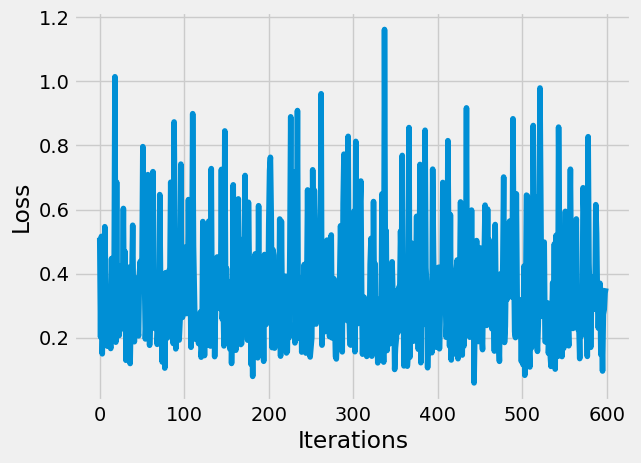

In [57]:
plt.style.use("fivethirtyeight")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.plot(losses)